In [6]:
import seaborn as sns
import numpy as np
from data import load_amp, load_uke
import pandas as pd
import warnings
from sklearn.metrics import RocCurveDisplay
import statsmodels.formula.api as smf

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from vae import VariationAutoencoderModule, KullbackLeiblerLoss, WassersteinLoss


PDQ_COLUMNS = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]
COVARIATES = ["Time since diagnosis", "Age", "Sex"]
EXTRA_COVARIATES = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "MoCA"]
SEED = 41
THRESHOLD = 10.9

class AmpData(Dataset):
    def __init__(self, path):
        super().__init__()
        X_amp, covariates_amp = load_amp(
            path,
            sample_one_measurement_per_subject=False,
        )
        X, y, extra_data = self.parse_data(X_amp, covariates_amp)
        
        included_predictions = (pd.isna(X[PDQ_COLUMNS]).sum(axis=1) <= 2) & (pd.isna(y[PDQ_COLUMNS]).sum(axis=1) <= 2)
        self.y = y[included_predictions][PDQ_COLUMNS].reset_index(drop=True).to_numpy(np.float32) / 100.0
        self.X = X[included_predictions][PDQ_COLUMNS].reset_index(drop=True).fillna(-100).to_numpy(np.float32) / 100.0
        self.extra_data = extra_data[included_predictions].reset_index(drop=True)
        

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

    def __len__(self):
        return len(self.X)

    @classmethod
    def cast_to_float(cls, data):
        for column in data.columns:
            data[column] = pd.to_numeric(data[column], errors="coerce")
        return data

    @classmethod
    def preprocess_covariates(cls, data):
        data = data.copy()
        data["Sex"] = data["Sex"].map({"Male": 0.0, "Female": 1.0})
        data = cls.cast_to_float(data)
        return data

    @classmethod
    def parse_data(cls, y, covariates):
        data = pd.concat(
            (y[["Participant", "Study", "Visit ID", *PDQ_COLUMNS,
            *EXTRA_COVARIATES]], covariates[COVARIATES]), axis=1
        ).dropna(thresh=4 + len(COVARIATES) + len(EXTRA_COVARIATES))
        data["Visit ID"] = data["Visit ID"].str[1:].astype(int)
        data = data[data["Study"] != "HBS"]

        X = []
        y = []
        extra_data = []

        for _, data in data.sort_values(
            ["Participant", "Visit ID"], ascending=True
        ).groupby(["Participant"]):
            for iloc, (_, row) in enumerate(data.iterrows()):
                if iloc > 0:
                    previous_row = data.iloc[iloc - 1]
                    previous_row = previous_row[PDQ_COLUMNS].to_list() + [
                        (row["Visit ID"] - previous_row["Visit ID"]) / 12.0
                    ]
                else:
                    previous_row = [np.nan] * (len(PDQ_COLUMNS) + 1)

                X.append(
                    previous_row + row[COVARIATES].to_list() + row[EXTRA_COVARIATES].to_list())
                y.append(row[PDQ_COLUMNS])
                extra_data.append([row["Study"]])

        return cls.preprocess_covariates(
            pd.DataFrame(X, columns=PDQ_COLUMNS +
                        ["Time since last visit"] + COVARIATES + EXTRA_COVARIATES)
        ), cls.cast_to_float(pd.DataFrame(y, columns=PDQ_COLUMNS).reset_index(drop=True)), pd.DataFrame(extra_data, columns=["Study"])

class PdqDataModule(L.LightningDataModule):
    def __init__(
        self,
        dataset: Dataset,
        ratio_var_dataset: float,
        batch_size: int,
    ):
        super().__init__()
        assert 0 < ratio_var_dataset <= 1

        self.data = dataset
        self.batch_size = batch_size

        if ratio_var_dataset < 1:
            self.val_start = int(len(self.data) * (1 - ratio_var_dataset))
        else:
            self.val_start = 0

    def train_dataloader(self):
        if self.val_start == 0:
            raise ValueError("Only the validation set is used.")
        return DataLoader(
            Subset(self.data, range(0, self.val_start)),
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=8,
        )

    def val_dataloader(self):
        return DataLoader(
            Subset(self.data, range(self.val_start, len(self.data))),
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=4,
        )
        
class PdqLoss:
    @property
    def n_values(self) -> int:
        return 8

    @property
    def last_layer_size(self) -> int:
        return 8

    def calculate_reconstruction(self, y_raw: torch.Tensor) -> torch.Tensor:
        return F.sigmoid(y_raw)

    def calculate_reconstruction_loss(self, y_true: torch.Tensor, y_pred: torch.Tensor):
        (_, y_true) = y_true
        missing_values = ~torch.isnan(y_true) 
        
        BCE = F.binary_cross_entropy_with_logits(input=y_pred[missing_values], target=y_true[missing_values], reduction='mean')
        #LOGC = -PdqLoss.sumlogC(y_pred[missing_values])
        return BCE #+ LOGC

    @staticmethod
    def sumlogC(x, eps = 1e-5):
        x = torch.clamp(x, eps, 1.-eps) 
        mask = torch.abs(x - 0.5).ge(eps)
        far = torch.masked_select(x, mask)
        close = torch.masked_select(x, ~mask)
        far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
        close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
        return far_values.sum() + close_values.sum()

dataset = AmpData("/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp_all.csv")
data_module = PdqDataModule(dataset, 0.1, 256)

In [ ]:
NAME = "vae_pdq"

reconstruction_loss = PdqLoss()
#generative_loss = KullbackLeiblerLoss(beta=1.0)
generative_loss = WassersteinLoss(reg_weight=100, kernel_type="imq", z_var=2.0)

model = VariationAutoencoderModule(
    reconstruction_loss,
    generative_loss,
    [8, 6, 2],
    patience=40,
    learning_rate=1e-3,
    dropout=0.05,
)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename=NAME,
    save_top_k=1,
    verbose=True,
    monitor="val_mean_diff",
    mode="min",
)
early_stopping = EarlyStopping(monitor="val_mean_diff", patience=80, mode="min")
logger = TensorBoardLogger("logs", name=NAME)

# Initialize the PyTorch Lightning trainer
trainer = L.Trainer(
    max_epochs=1000, callbacks=[early_stopping], logger=logger, log_every_n_steps=6
)

trainer.fit(model, data_module)

In [7]:
model = VariationAutoencoderModule.load_from_checkpoint(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/conditional/logs/vae_pdq/version_1/checkpoints/epoch=80-step=567.ckpt"
).model.eval()

Layers Encoder [8, 8, 6, 2]


In [9]:
X_uke, covariates_uke, extra_data_uke, y_uke = load_uke(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv",
    PDQ_COLUMNS + EXTRA_COVARIATES,
)

X_uke = pd.concat(
    (
        X_uke,
        extra_data_uke[["Time since last test"]].rename(
            columns={"Time since last test": "Time since last visit"}
        ),
        covariates_uke[COVARIATES],
    ),
    axis=1,
)
full_measurements_uke = pd.isna(X_uke).sum(axis=1) < 4
X_uke = AmpData.preprocess_covariates(X_uke)[full_measurements_uke]
covariates_uke = covariates_uke[full_measurements_uke]
extra_data_uke = extra_data_uke[full_measurements_uke]
y_uke = y_uke[full_measurements_uke]

<Axes: xlabel='z1', ylabel='z2'>

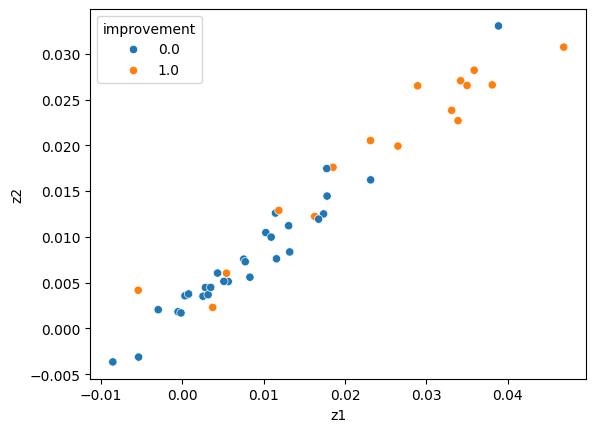

In [26]:
uke_data_tensor = torch.tensor((X_uke[PDQ_COLUMNS].fillna(-100) / 100.0).astype(np.float32).to_numpy())

mu, _ = model.encoder(uke_data_tensor)
mu = pd.DataFrame(mu.detach().numpy(), columns=["z1", "z2"])
mu["improvement"] = (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float)

sns.scatterplot(data=mu, x="z1", y="z2", hue="improvement")

Optimization terminated successfully.
         Current function value: 0.465839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.505234
         Iterations 6


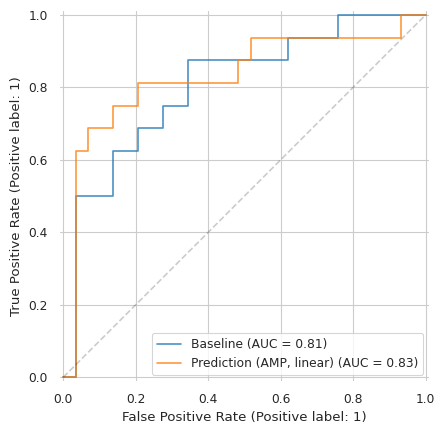

In [29]:
amp_expected_change = smf.logit(
    "improvement ~ z1 + z2", data=mu
).fit()

baseline_data = pd.DataFrame.from_dict(
    {
        "pre_pdq": X_uke[PDQ_COLUMNS].mean(axis=1),
        "updrs_iii_change": extra_data_uke["UPDRS III: Change"],
        "diagnosis_time": covariates_uke["Time since diagnosis"],
        "improvement": (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float),
    }
)

custom_data = pd.concat((mu.drop(columns=["improvement"]), baseline_data), axis=1).dropna().astype(float)


baseline = smf.logit(
    "improvement ~ pre_pdq + updrs_iii_change + diagnosis_time", data=custom_data
).fit()

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        baseline.predict(custom_data),
        name="Baseline",
        alpha=0.8
    )
    
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        amp_expected_change.predict(custom_data),
        name="Prediction (AMP, linear)",
        ax=viz.ax_,
        alpha=0.8
    )

    sns.despine(top=True, bottom=True, left=True, right=True)
    
    viz.ax_.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.2)